<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Cristina Vazquez, Gerardo Ruiz Velasco Lazalde.

**Fecha:** 7 de mayo del 2021.

**Expediente** : 721215 ,715878 .
**Profesor:** Oscar David Jaramillo Zuluaga.

**Link repositorio: https://github.com/GerardoRVL97/TAREA_11_RUIZ_G_VAZQUEZ_C **

# Tarea 11: Clase:24 Valuacion Opciones Barrera

# Tarea
Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

In [26]:
def Riemann_approach_Trap(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',tipo:'call o put',
                    flag=None):
    t_emp = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Creamos el segundo DataFrame
    mult= pd.DataFrame(2+r*(T/NbStep)+np.random.randn(NbTraj,NbStep)*sigma).T
    # Multiplicamos los dataframes
    prices_mult= prices*mult
    # Hacemos la sumatoria
    sumprices_mult = np.cumsum(prices_mult)
    # Multiplicamos por h/2 
    sumatoria = sumprices_mult*(1/NbStep)*(1/2)*(1/T)
    # Definimos el dataframe de strikes
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t)
    if tipo =='call':
        # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
        valor = pd.DataFrame({'Prima':np.exp(-r*T) \
                             *np.fmax(sumatoria-strike,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
        # intervalos de confianza
        #confianza = 0.95
        #sigma_est = call.sem().Prima
        #mean_est = call.iloc[-1].Prima
        #i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
        #return call.iloc[-1].Prima, i1
    else:
        valor = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(strike-sumatoria,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
        # intervalos de confianza
    confianza = 0.95
    sigma_est = valor.sem().Prima
    mean_est = valor.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    dif95 = np.round(i1[1] - i1[0],4)
    t_acab = time.time()
    e = int(t_acab - t_emp)
    time_format = '{:02d}:{:02d}'.format((e % 3600 // 60), e % 60)
    tiempo = lambda x: '< 1 s' if x == '00:00' else x
    return np.array([np.round(valor.iloc[-1].Prima,4),np.round(i1[0],4),np.round(i1[1],4),dif95,
                     tiempo(time_format)])
    #return .iloc[-1].Prima, i1

In [27]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [28]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

## Respuesta Cristina

Obtenfo los precios de cierre para poder ver el comportamiendo del activo en este caso Microsoft. Vemos que claramente la tendencia es que el precio continue subiendo.

In [29]:
closes = get_adj_closes(['MSFT'], '2017-01-01')
closes_msft = closes.loc[:,'MSFT']
closes_msft[-1]

252.4600067138672

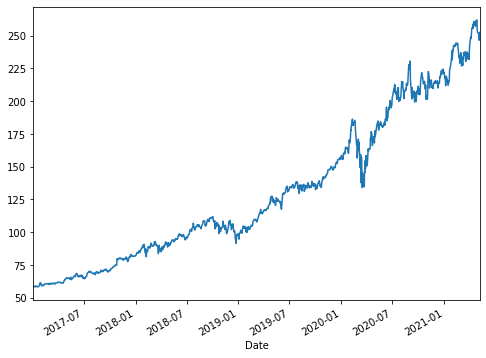

In [30]:
closes_msft.plot(figsize=(8,6));

## Calculamos los rendimientos

In [31]:
ret_msft = calc_daily_ret(closes_msft)

## Descargamos datos de las opciones para poder valuarlos

In [32]:
pd.set_option('display.max_rows', 10)

msft = web.YahooOptions('MSFT')
msft_opt = msft.get_all_data().reset_index()
msft_opt.set_index('Expiry').sort_index().head(5)

,Strike,Type,Symbol,...,Quote_Time,Last_Trade_Date,JSON
Expiry,,,,,,,
2021-05-07,200.0,call,MSFT210507C00200000,...,2021-05-07 20:00:02,2021-05-05 19:00:24,"{'contractSymbol': 'MSFT210507C00200000', 'str..."
2021-05-07,155.0,put,MSFT210507P00155000,...,2021-05-07 20:00:02,2021-04-23 17:46:50,"{'contractSymbol': 'MSFT210507P00155000', 'str..."
2021-05-07,120.0,put,MSFT210507P00120000,...,2021-05-07 20:00:02,2021-05-03 13:30:01,"{'contractSymbol': 'MSFT210507P00120000', 'str..."
2021-05-07,120.0,call,MSFT210507C00120000,...,2021-05-07 20:00:02,2021-05-06 19:59:12,"{'contractSymbol': 'MSFT210507C00120000', 'str..."
2021-05-07,252.5,put,MSFT210507P00252500,...,2021-05-07 20:00:02,2021-05-07 19:59:33,"{'contractSymbol': 'MSFT210507P00252500', 'str..."


## Sonrisa de Volatilidad
La utilizamos para definir tanto el strike como el valor de la barrera

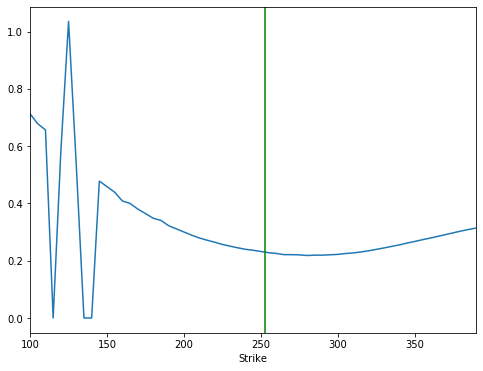

In [33]:
call_opt = msft_opt.loc[(msft_opt.Expiry== '2021-09-17') & (msft_opt.Type=='call')]

ax = call_opt.set_index('Strike').loc[:, 'IV'].plot(figsize=(8,6))
ax.axvline(call_opt.Underlying_Price.iloc[0], color='g');

In [34]:
call_opt.Underlying_Price.iloc[0]

252.46

In [35]:
K=260
opt_deseada = msft_opt.loc[(msft_opt.Type=='call') & (msft_opt.Strike==K) & (msft_opt.Expiry=='2021-09-17')]
opt_deseada

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
1136,260.0,2021-09-17,call,...,2021-05-07 20:00:02,2021-05-07 19:56:00,"{'contractSymbol': 'MSFT210917C00260000', 'str..."


In [36]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            260
Expiry                                            2021-09-17 00:00:00
Type                                                             call
Symbol                                            MSFT210917C00260000
Last                                                             10.4
                                          ...                        
Underlying                                                       MSFT
Underlying_Price                                                  252
Quote_Time                                        2021-05-07 20:00:02
Last_Trade_Date                                   2021-05-07 19:56:00
JSON                {'contractSymbol': 'MSFT210917C00260000', 'str...
Name: 1136, Length: 19, dtype: object

## Simulación de Precios -  Modelo Normal

In [37]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = 0.0006/360
mu, sigma, r

(0.0013372091431082382, 0.01797312595647632, 1.6666666666666665e-06)

In [38]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

## Valuación Europea

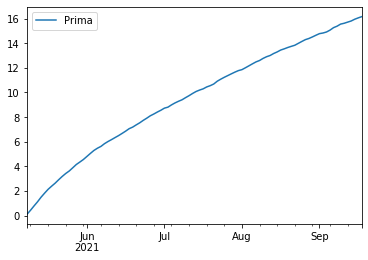

In [39]:
strike = K
call_ren=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0).mean(axis=1)}, index=dates)
call_ren.plot();

## Intervalo de Confianza

In [40]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call_ren.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(15.267738791113382, 17.04560484411831)


## Valuación Barrera

In [41]:
S0

252.4600067138672

In [42]:
pd.set_option('display.max_columns', 15)

# Precio barrera
B = 250    

# Función de activación (knock-outb)
# Si en algún momento el precio toca la barrera la opción se activa
I = (sim_closes > B).cumprod(axis=0) > 0

## Comparación de Primas

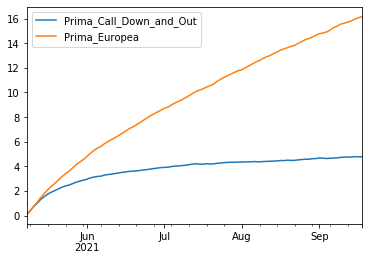

In [43]:
# Opción Europea
call = pd.DataFrame({'Prima_Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)},index=dates)
# Opción barrera
callui = pd.DataFrame({'Prima_Call_Down_and_Out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Comparativo
ax = callui.plot();
call.plot(ax=ax);


## Simular Precios - Método de Histograma

In [44]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

## Comparación de Primas

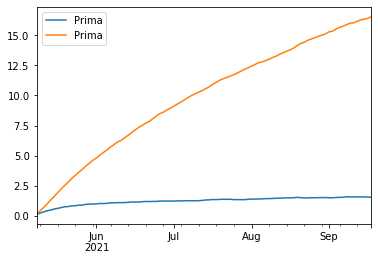

In [45]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
calleu_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
callb_hist = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(I*sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)

ax = callb_hist.plot();
calleu_hist.plot(ax=ax);

## Intervalo de Confianza

In [46]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = calleu_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(15.648721386202272, 17.433777213876734)


## Resultados

In [49]:
call_final= pd.DataFrame(index=['Precio'] , columns=['Real','Call Europeo normal', 'Call D&O normal',
                                                     'Call Europeo histograma', 'Call D&O histograma'])
call_final['Real'] = opt_valuar['JSON']['lastPrice']
call_final['Call Europeo normal'] = call.iloc[-1].values
call_final['Call D&O normal'] =  callui.iloc[-1].values
call_final['Call Europeo histograma'] = calleu_hist.iloc[-1].values
call_final['Call D&O histograma'] =  callb_hist.iloc[-1].values
call_final

,Real,Call Europeo normal,Call D&O normal,Call Europeo histograma,Call D&O histograma
Precio,10.4,16.157,4.777,16.541,1.555
